# Introduction to Neural Networks 


** Ecole Centrale Nantes **

** Diana Mateus **


** Participants : **



## General description
In this lab we will create a simple classifier based on neural networks. We will progress in two parts:
- In the first part, and to better understand the involved operations, we will create a single-neuron model and optimize its parameters "by hand". For this first part we will only use the **Numpy** library
- We will then build a multi-layer perceptron with the built-in library **Keras** module and **tensorflow**. Tensorflow is already installed in the university computers. If using your own computer you should have already installed **tensorflow** or use **collab** online platform.




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

### Loading the dataset
Start by runing the following lines to load and visualize the data.

In [5]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) 
    train_y = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) 
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

train_x, train_y, test_x, test_y, classes=load_dataset()

#### Visualize data

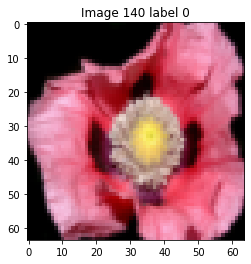

Train X shape: (209, 64, 64, 3)
We have 209 images of dimensionality 64x64x3


In [ ]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)
index = np.random.randint(low=0,high=train_y.shape[1])
plt.imshow(train_x[index])
plt.title("Image "+str(index)+" label "+str(train_y[0,index]))
plt.show()
print ("Train X shape: " + str(train_x.shape))
print ("We have "+str(train_x.shape[0]), 
       "images of dimensionality " 
       + str(train_x.shape[1])+ "x"
       + str(train_x.shape[2])+ "x"
       + str(train_x.shape[3]))

#### Preprocessing
In the following lines we vectorize the images (Instead of a 2-D image we will give as input to the models a 1-D vector). The normalization makes the image intensities be between 0 and 1, and converts the images to floats.

In [ ]:
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(train_y.shape))
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Train X shape: (12288, 209)
Train Y shape: (1, 209)
Test X shape: (12288, 50)
Test Y shape: (1, 50)


In [ ]:
train_x = train_x/255.
test_x = test_x/255.
print(train_x.shape)

(12288, 209)


### 1. Classification with a single neuron 


**a)** Fill-in the following three functions to define the single neuron model:
- A function **initialize_parameters** that randomly initializes the model's weights with small values. The number of the weights corresponds to the dimension of the input (size of the image)
- A function **sigmoid** that computes the sigmoid activation function
- A function **neuron** that given an input vector, weights and biases computes the output of the single neuron model

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [ ]:
def initialize_parameters(dim):
    w = np.random.randn(dim,1)
    w=(w*0.01).T
    b = np.random.randn(1,1)
    b=b*0.01
    return w, b

In [ ]:
def neuron(w,b,X):
    pred_y = sigmoid(np.dot(w,X)+b)
    return pred_y

**b)** **Forward Pass:**
Use the three functions above to compute a first forward pass for the input matrix $X$ containing the loaded dataset, for some initialization of the weights and bias.
 
 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}
 

In [ ]:
w,b=initialize_parameters(train_x.shape[0])
print("w:",w.shape,"b:",b.shape)
pred_y=neuron(w,b,train_x)

w: (1, 12288) b: (1, 1)


**c) Cost estimation:**
 
We will use a binary cross-entropy loss, so that the empirical risk can be computed as:
 \begin{align}
 E = - \frac{1}{m} \sum_{i=1}^m 
 y^{(i)} \log(y_{\rm pred}^{(i)}) +
 (1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
 \end{align}
 
 The following cross-entropy function should give as result the scalar cost value computed over the entire dataset

In [ ]:
def crossentropy(Y,Ypred):
    cost_sum=0
    for i in range(1,Y.size):
      cost = Y[0][i]*np.log(Ypred[0][i])+(1-Y[0][i])*np.log(1-Ypred[0][i]) 
      cost_sum=cost_sum+cost
    cost=(-1/Y.size)*cost_sum
    return cost

print("The cross-entropy loss is:",crossentropy(train_y,pred_y))

The cross-entropy loss is: 0.7174261271248945


**d) Back propagation:**

After initializing the parameters and doing a forward pass, we need to backpropagate the cost by computing the gradient with respect to the model parameters to later update the weights

\begin{align}
\frac{\partial E}{\partial w} = & \frac{1}{m} X(Y_{\rm pred}-Y)^T\\
\frac{\partial E}{\partial b} = & \frac{1}{m} (Y_{\rm pred}-Y)\\
\end{align}

See a demonstration of how the gradient was computed in 
https://en.wikipedia.org/wiki/Cross_entropy

Fill-in the backpropagation function which receives as input the the training set (X,Y), as well as the current predictions and returns the gradients updates for the weights and bias

Hint: When the error is computed for several samples simultaneously, the gradient is averaged over the contribution of different samples.

In [ ]:
def backpropagate(X, Y, Ypred):
    m = X.shape[1]
    dw_sum=0
    db_sum=0

    dw=(np.dot(X ,(Ypred - Y).T)).sum(axis=1, keepdims=True) / m
    db = (Ypred - Y).sum(axis=1, keepdims=True) / m
    grads = {"dw": dw,
             "db": db} 
    
    return grads

grads=backpropagate(train_x,train_y, pred_y)

print("dw:",grads["dw"])
print("db:",grads["db"])

dw: [[0.0596526 ]
 [0.07734562]
 [0.06612345]
 ...
 [0.05739458]
 [0.07075438]
 [0.0414357 ]]
db: [[0.17741382]]


**e) Optimization**
After initializing the parameters, computing the cost function, and calculating gradients, we can now update the parameters using gradient descent. Use the functions implemented above to fill_in the "gradient_descent" function that optimizes the parameters given a training set X, Y, a fixed number of iterations, and a learning_rate. Store and plot the value of the loss function at each iteration

In [ ]:
def gradient_descent(X, Y, iterations, learning_rate):
    costs = []
    w, b = initialize_parameters(train_x.shape[0])
    
    for i in range(iterations):
        Ypred = neuron(w,b,X)
        cost = crossentropy(Y,Ypred)
        grads= backpropagate(X,Y,Ypred)
        
        #update parameters
        w -= learning_rate*grads["dw"].T
        b -= learning_rate*grads["db"].T
        costs.append(cost)
        
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return w,b, costs

w, b, costs = gradient_descent(train_x,train_y,iterations=2000, learning_rate = 0.0035)



Cost after iteration 0: 0.810535
Cost after iteration 100: 0.519316
Cost after iteration 200: 0.457151
Cost after iteration 300: 0.413204
Cost after iteration 400: 0.379050
Cost after iteration 500: 0.351201
Cost after iteration 600: 0.327796
Cost after iteration 700: 0.307702
Cost after iteration 800: 0.290173
Cost after iteration 900: 0.274691
Cost after iteration 1000: 0.260878
Cost after iteration 1100: 0.248453
Cost after iteration 1200: 0.237197
Cost after iteration 1300: 0.226939
Cost after iteration 1400: 0.217543
Cost after iteration 1500: 0.208898
Cost after iteration 1600: 0.200912
Cost after iteration 1700: 0.193508
Cost after iteration 1800: 0.186622
Cost after iteration 1900: 0.180200


**e) Plot the training curve**
Plot the evolution of the cost vs the iterations 

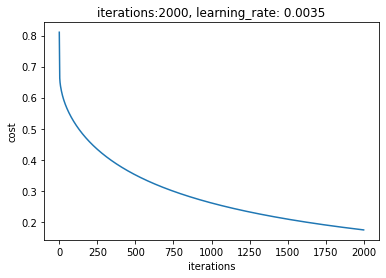

In [ ]:
plt.plot(costs)
plt.title("iterations:2000, learning_rate: 0.0035")
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

**f) Prediction**
Use the optimized parameters to make predictions both for the train and test sets and compute the accuracy for each. What do you observe?

In [ ]:
def predict(w, b, X):    
    y_pred=neuron(w,b,X)
    return y_pred

# predict 
train_pred_y = predict(w, b, train_x)
test_pred_y = predict(w, b, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))
    

Train Acc: 85.00731065409293 %
Test Acc: 64.55727207304636 %


**g) Early stopping** 
- Adapt the gradient descent function to consider part (a percentage) of the training data for validation. Use the validation set to choose the training hyperparameters (learning_rate, iterations). 
- Plot the training and validation curves
- Report again the training and test accuracy and loss for the new trained model
- What do you observe



best iteration: 126
best_w: [[ 0.01108934 -0.01877379 -0.01691811 ...  0.00902245 -0.02070377
   0.010355  ]]
best_b: [[-0.03796091]]


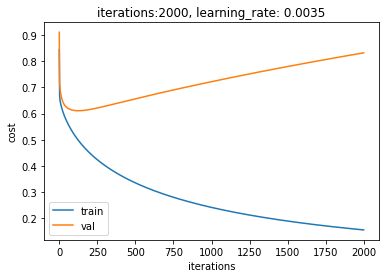

Train Acc: 83.08450346177663 %
Test Acc: 65.58926527675573 %


In [ ]:
def gradient_descent_early_stopping(X, Y, iterations, learning_rate, percentage=.1):
    data=np.concatenate((X,Y),axis=0)
    train,val=train_test_split(data.T,test_size=percentage)
    train_x=train[ : , :train[0].size-1].T
    train_y=train[ : , train[0].size-1].T
    train_y=np.atleast_2d(train_y)
    train_costs=[]
    val_x=val[ : , :val[0].size-1].T
    val_y=val[ : , val[0].size-1].T
    val_y=np.atleast_2d(val_y)
    val_costs = []
    ws=[]
    bs=[]

    train_w, train_b = initialize_parameters(train_x.shape[0])
    
    for i in range(iterations):
        train_pred_y = neuron(train_w,train_b,train_x)
        val_pred_y=predict(train_w,train_b,val_x)
        train_cost = crossentropy(train_y,train_pred_y)
        train_costs.append(train_cost)
        val_cost=crossentropy(val_y,val_pred_y)
        val_costs.append(val_cost)
        grads= backpropagate(train_x,train_y,train_pred_y)
        
        ws.extend(train_w)
        bs.extend(train_b)
        #update parameters
        train_w -= learning_rate*grads["dw"].T
        train_b -= learning_rate*grads["db"].T

    best_val=val_costs.index(min(val_costs))
    print("best iteration:", val_costs.index(min(val_costs)))
    best_w=ws[best_val]
    best_b=bs[best_val]
    best_w=np.atleast_2d(best_w)
    best_b=np.atleast_2d(best_b)


    return best_w,best_b,train_costs,val_costs

best_w,best_b,train_costs,val_costs=gradient_descent_early_stopping(train_x,train_y,2000,0.0035)

print("best_w:",best_w)
print("best_b:",best_b)

plt.plot(train_costs,label="train")
plt.plot(val_costs,label="val")
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("iterations:2000, learning_rate: 0.0035")
plt.legend()
plt.show() 

train_pred_y = predict(best_w, best_b, train_x)
test_pred_y = predict(best_w, best_b, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))


### 2. CNNs with Keras

Adapt the example in this website https://keras.io/examples/vision/mnist_convnet/ to our problem. To this end:
- change the number of classes and the input size
- remove the expand_dims(x_train, -1): it is not necessary to expand the dimensions since our input is 3-dimensional 
- you may need to transpose the labels vector
- change the categorical cross-entropy to the binary cross entropy given that our problem is binary classification. 
- also change the softmax to sigmoid, the more appropriate activation function for binary data

We can choose a single neuron output passed through sigmoid, and then set a threshold to choose the class, or use two neuron output and then perform a softmax.

**2.1** Can you get the accuracy better than in our hand single-neuron model?Try different configurations and explain the changes you have made.

**2.2** Compute the train and test loss and accuracy after the model has been trained.  What model parameters does the ``fit`` function retain?

**2.3** How many parameters does the network have, explain where the number comes from.

**2.4** What is the receptive field of the network https://distill.pub/2019/computing-receptive-fields/

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# the data, split between train and test sets
x_train, y_train, x_test, y_test, classes=load_dataset()
num_classes=classes.size
print(num_classes)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print(x_train.shape)

# convert class vectors to binary class matrices
y_train = y_train.T
y_test = y_test.T
print(y_train.shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




2
(209, 64, 64, 3)
(209, 1)


In [ ]:
#build the model
input_shape=(64,64,3)
model1 =keras.Sequential(
    [keras.Input(shape=input_shape),
     layers.Conv2D(32,(3,3),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(64,(3,3),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dropout(0.5),
     layers.Dense(num_classes,activation="sigmoid")
     
    ])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12544)            

In [ ]:
#comiple and fit
batch_size=128
epochs=30
model1.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
result1=model1.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 2s 500ms/step - loss: 0.7077 - accuracy: 0.5904 - val_loss: 0.5424 - val_accuracy: 0.8095
Epoch 2/30
2/2 [==============================] - 1s 362ms/step - loss: 0.6560 - accuracy: 0.6383 - val_loss: 0.5830 - val_accuracy: 0.8095
Epoch 3/30
2/2 [==============================] - 1s 370ms/step - loss: 0.6316 - accuracy: 0.6383 - val_loss: 0.5449 - val_accuracy: 0.8095
Epoch 4/30
2/2 [==============================] - 1s 365ms/step - loss: 0.6143 - accuracy: 0.6383 - val_loss: 0.5071 - val_accuracy: 0.8095
Epoch 5/30
2/2 [==============================] - 1s 389ms/step - loss: 0.5840 - accuracy: 0.6383 - val_loss: 0.5041 - val_accuracy: 0.8095
Epoch 6/30
2/2 [==============================] - 1s 358ms/step - loss: 0.5592 - accuracy: 0.6383 - val_loss: 0.4943 - val_accuracy: 0.8095
Epoch 7/30
2/2 [==============================] - 1s 366ms/step - loss: 0.5385 - accuracy: 0.6383 - val_loss: 0.4870 - val_accuracy: 0.8095
Epoch 8/30
2/2 [====

In [ ]:
score1 = model1.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6729187965393066
Test accuracy: 0.7799999713897705


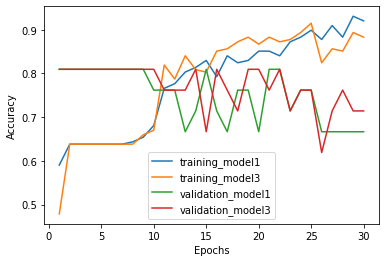

In [9]:
#convolutional layer of (5,5) kernel size instead of (3,3)
input_shape=(64,64,3)
model3 =keras.Sequential(
    [keras.Input(shape=input_shape),
     layers.Conv2D(32,(5,5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(64,(5,5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dropout(0.5),
     layers.Dense(num_classes,activation="sigmoid")
     
    ])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_1 (Dropout)         (None, 10816)            

In [ ]:

batch_size=128
epochs=30
model3.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
result3=model3.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 2s 739ms/step - loss: 0.7293 - accuracy: 0.4787 - val_loss: 0.5555 - val_accuracy: 0.8095
Epoch 2/30
2/2 [==============================] - 2s 578ms/step - loss: 0.6426 - accuracy: 0.6383 - val_loss: 0.5673 - val_accuracy: 0.8095
Epoch 3/30
2/2 [==============================] - 2s 583ms/step - loss: 0.6217 - accuracy: 0.6383 - val_loss: 0.5077 - val_accuracy: 0.8095
Epoch 4/30
2/2 [==============================] - 2s 577ms/step - loss: 0.6098 - accuracy: 0.6383 - val_loss: 0.5083 - val_accuracy: 0.8095
Epoch 5/30
2/2 [==============================] - 2s 582ms/step - loss: 0.5757 - accuracy: 0.6383 - val_loss: 0.4967 - val_accuracy: 0.8095
Epoch 6/30
2/2 [==============================] - 2s 588ms/step - loss: 0.5500 - accuracy: 0.6383 - val_loss: 0.4784 - val_accuracy: 0.8095
Epoch 7/30
2/2 [==============================] - 2s 589ms/step - loss: 0.5232 - accuracy: 0.6383 - val_loss: 0.4668 - val_accuracy: 0.8095
Epoch 8/30
2/2 [====

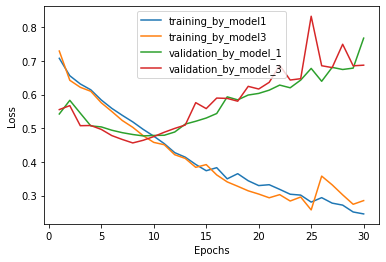

In [ ]:
#(5,5)(model3) vs (3,3)(model1)
plt.plot(range(1, epochs+1), result1.history['loss'], label="training_by_model1")
plt.plot(range(1, epochs+1), result3.history['loss'], label="training_by_model3")
plt.plot(range(1, epochs+1), result1.history['val_loss'], label="validation_by_model_1")
plt.plot(range(1, epochs+1), result3.history['val_loss'], label="validation_by_model_3")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


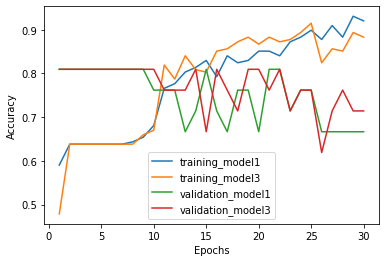

In [ ]:
#(5,5)(model3) vs (3,3)(model1)
plt.plot(range(1, epochs+1), result1.history['accuracy'], label="training_model1")
plt.plot(range(1, epochs+1), result3.history['accuracy'], label="training_model3")
plt.plot(range(1, epochs+1), result1.history['val_accuracy'], label="validation_model1")
plt.plot(range(1, epochs+1), result3.history['val_accuracy'], label="validation_model3")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score1 = model1.evaluate(x_test, y_test, verbose=0)
score3 = model3.evaluate(x_test, y_test, verbose=0)
print("Test loss model 1:", score1[0])
print("Test accuracy model 1:", score1[1])
print("Test loss model 3:", score3[0])
print("Test accuracy model 3:", score3[1])

Test loss model 1: 0.7324665784835815
Test accuracy model 1: 0.699999988079071
Test loss model 3: 0.48865172266960144
Test accuracy model 3: 0.8799999952316284


In [ ]:
#average pooling instead of maximum pooling
input_shape=(64,64,3)
model2 =keras.Sequential(
    [keras.Input(shape=input_shape),
     layers.Conv2D(32,(3,3),activation="relu"),
     layers.AveragePooling2D(pool_size=(2,2)),
     layers.Conv2D(64,(3,3),activation="relu"),
     layers.AveragePooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dropout(0.5),
     layers.Dense(num_classes,activation="sigmoid")
     
    ])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 average_pooling2d_6 (Averag  (None, 31, 31, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 average_pooling2d_7 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten_7 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_7 (Dropout)         (None, 12544)            

In [ ]:
batch_size=128
epochs=30
model2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
result2=model2.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 2s 456ms/step - loss: 0.6750 - accuracy: 0.5691 - val_loss: 0.5348 - val_accuracy: 0.8095
Epoch 2/30
2/2 [==============================] - 1s 317ms/step - loss: 0.6530 - accuracy: 0.6383 - val_loss: 0.5480 - val_accuracy: 0.8095
Epoch 3/30
2/2 [==============================] - 1s 315ms/step - loss: 0.6195 - accuracy: 0.6383 - val_loss: 0.5564 - val_accuracy: 0.8095
Epoch 4/30
2/2 [==============================] - 1s 311ms/step - loss: 0.6011 - accuracy: 0.6383 - val_loss: 0.5213 - val_accuracy: 0.8095
Epoch 5/30
2/2 [==============================] - 1s 313ms/step - loss: 0.5828 - accuracy: 0.6383 - val_loss: 0.5119 - val_accuracy: 0.8095
Epoch 6/30
2/2 [==============================] - 1s 319ms/step - loss: 0.5554 - accuracy: 0.6383 - val_loss: 0.5216 - val_accuracy: 0.8095
Epoch 7/30
2/2 [==============================] - 1s 324ms/step - loss: 0.5319 - accuracy: 0.6489 - val_loss: 0.5006 - val_accuracy: 0.8095
Epoch 8/30
2/2 [====

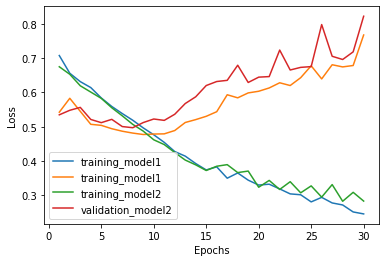

In [ ]:
#average pooling(model2) vs maximum pooling(model1)
plt.plot(range(1, epochs+1), result1.history['loss'], label="training_model1")
plt.plot(range(1, epochs+1), result1.history['val_loss'], label="training_model1")
plt.plot(range(1, epochs+1), result2.history['loss'], label="training_model2")
plt.plot(range(1, epochs+1), result2.history['val_loss'], label="validation_model2")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

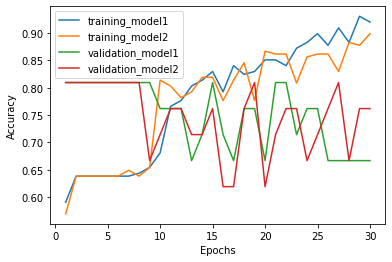

In [ ]:
#average pooling(model2) vs maximum pooling(model1)
plt.plot(range(1, epochs+1), result1.history['accuracy'], label="training_model1")
plt.plot(range(1, epochs+1), result2.history['accuracy'], label="training_model2")
plt.plot(range(1, epochs+1), result1.history['val_accuracy'], label="validation_model1")
plt.plot(range(1, epochs+1), result2.history['val_accuracy'], label="validation_model2")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score2 = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

Test loss: 0.7406442165374756
Test accuracy: 0.7400000095367432


In [ ]:
#introduce padding
input_shape=(64,64,3)
model4 =keras.Sequential(
    [keras.Input(shape=input_shape),
     layers.Conv2D(32,(3,3),activation="relu",padding="same"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(64,(3,3),activation="relu",padding="same"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dropout(0.5),
     layers.Dense(num_classes,activation="sigmoid")
     
    ])
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_9 (Dropout)         (None, 16384)            

In [ ]:

batch_size=128
epochs=30
model4.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
result4=model4.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 2s 554ms/step - loss: 0.6864 - accuracy: 0.6011 - val_loss: 0.5314 - val_accuracy: 0.8095
Epoch 2/30
2/2 [==============================] - 1s 402ms/step - loss: 0.6500 - accuracy: 0.6383 - val_loss: 0.5669 - val_accuracy: 0.8095
Epoch 3/30
2/2 [==============================] - 1s 403ms/step - loss: 0.6245 - accuracy: 0.6383 - val_loss: 0.5262 - val_accuracy: 0.8095
Epoch 4/30
2/2 [==============================] - 1s 402ms/step - loss: 0.6001 - accuracy: 0.6383 - val_loss: 0.4911 - val_accuracy: 0.8095
Epoch 5/30
2/2 [==============================] - 1s 403ms/step - loss: 0.5862 - accuracy: 0.6383 - val_loss: 0.5020 - val_accuracy: 0.8095
Epoch 6/30
2/2 [==============================] - 1s 400ms/step - loss: 0.5543 - accuracy: 0.6436 - val_loss: 0.5121 - val_accuracy: 0.8095
Epoch 7/30
2/2 [==============================] - 1s 392ms/step - loss: 0.5370 - accuracy: 0.6702 - val_loss: 0.4666 - val_accuracy: 0.8095
Epoch 8/30
2/2 [====

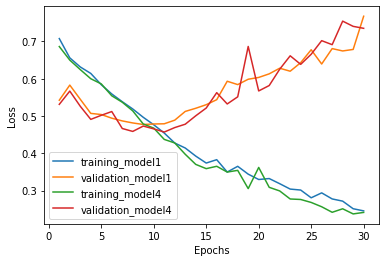

In [ ]:
#padding(model4) vs no padding(model1)
plt.plot(range(1, epochs+1), result1.history['loss'], label="training_model1")
plt.plot(range(1, epochs+1), result1.history['val_loss'], label="validation_model1")
plt.plot(range(1, epochs+1), result4.history['loss'], label="training_model4")
plt.plot(range(1, epochs+1), result4.history['val_loss'], label="validation_model4")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

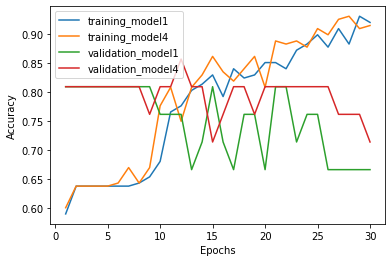

In [ ]:
#padding(model4) vs no padding(model1)
plt.plot(range(1, epochs+1), result1.history['accuracy'], label="training_model1")
plt.plot(range(1, epochs+1), result4.history['accuracy'], label="training_model4")
plt.plot(range(1, epochs+1), result1.history['val_accuracy'], label="validation_model1")
plt.plot(range(1, epochs+1), result4.history['val_accuracy'], label="validation_model4")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score4 = model4.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score4[0])
print("Test accuracy:", score4[1])

Test loss: 0.5265060663223267
Test accuracy: 0.7799999713897705


In [ ]:
#receptive field


In [ ]:
#Adding strides
input_shape=(64,64,3)
model5 =keras.Sequential(
    [keras.Input(shape=input_shape),
     layers.Conv2D(32,(3,3),activation="relu",strides=(2,2)),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(64,(3,3),activation="relu",strides=(2,2)),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dropout(0.5),
     layers.Dense(num_classes,activation="sigmoid")
     
    ])
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 31, 31, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 576)               0         
                                                                 
 dropout_12 (Dropout)        (None, 576)             

In [ ]:
#comiple and fit
batch_size=128
epochs=30
model5.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
result5=model5.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 1s 241ms/step - loss: 0.6817 - accuracy: 0.5904 - val_loss: 0.5886 - val_accuracy: 0.8095
Epoch 2/30
2/2 [==============================] - 0s 75ms/step - loss: 0.6655 - accuracy: 0.6383 - val_loss: 0.5661 - val_accuracy: 0.8095
Epoch 3/30
2/2 [==============================] - 0s 83ms/step - loss: 0.6639 - accuracy: 0.6383 - val_loss: 0.5629 - val_accuracy: 0.8095
Epoch 4/30
2/2 [==============================] - 0s 94ms/step - loss: 0.6522 - accuracy: 0.6383 - val_loss: 0.5600 - val_accuracy: 0.8095
Epoch 5/30
2/2 [==============================] - 0s 74ms/step - loss: 0.6338 - accuracy: 0.6383 - val_loss: 0.5607 - val_accuracy: 0.8095
Epoch 6/30
2/2 [==============================] - 0s 74ms/step - loss: 0.6366 - accuracy: 0.6383 - val_loss: 0.5632 - val_accuracy: 0.8095
Epoch 7/30
2/2 [==============================] - 0s 77ms/step - loss: 0.6366 - accuracy: 0.6383 - val_loss: 0.5643 - val_accuracy: 0.8095
Epoch 8/30
2/2 [==========

In [ ]:
score5 = model5.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score5[0])
print("Test accuracy:", score5[1])

Test loss: 0.6102567315101624
Test accuracy: 0.7200000286102295


## BONUS: 
Replace the fit function by your own tensorflow  implementation

1. Instantiate one of keras.optimizers to train the model.

optimizer = 

2. Instantiate a loss from keras.losses

loss_fn = 

3. Prepare the metrics. Instatiate the metrics from keras.metrics

train_acc_metric =
val_acc_metric =

4. Stochastic Gradient Loop
    * Iterate over the dataset in batches with 
    * Open a GradientTape() scope 
    * Inside this scope call the model (forward pass)
    * Compute the loss outside the scope
    * Retrieve the weight gradients
    * Use the optimimzer to update the weights with the gradients



In [ ]:
import pandas as pd
def stochastic_gradient_loop(X,Y):
  #dataset=pd.DataFrame({'X':X,'Y':Y})
  #print(len(dataset))
  optimizer=keras.optimizers.Adam(learning_rate=0.005)
  loss_fn=keras.losses.BinaryCrossentropy()
  train_acc_metric=val_acc_metric=keras.metrics.Accuracy()
  for step,(X,Y) in enumerate(dataset):
     with tf.GradientTape as tape:
       pred_Y=model(X)
     loss_value=loss_fn(Y,pred_Y)
     train_acc_metric.update_state(y,pred_Y)
  gradients=tape.gradient(loss_value,model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))
  if step%100==0:
    print('Step:',step)
    print('Total running accuracy so far: %.3f' % train_acc_metric.result())